# 风格迁移
### Ng的最后一个内容，用VGG实现的图片的风格迁移，依旧是加载好训练好的模型

In [ ]:
import os
import tensorflow as tf
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import st_utils
import numpy as np

In [ ]:
def compute_content_cost(a_C, a_G):
    """
    计算content损失
    Args:
        a_C: content图片的激活层输出（1，n_w，n_h，n_c）
        a_G: generate图片的激活层输出（1，n_w，n_h，n_c）
    Returns:
        J_content: 计算得到的content损失
    """
    # 获取维度信息
    m, n_h, n_w, n_c = a_G.get_shape()
    # 改变a_C，a_G的形状（降维，去掉第一个维度）
    a_C_unrolled = tf.reshape(a_C, [n_h, n_w, n_c])
    a_G_unrolled = tf.reshape(a_G, [n_h, n_w, n_c])
    # 计算损失函数
    J_content =  1./(4 * n_h * n_w * n_c) * tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))

    return J_content

In [ ]:
def gram_matrix(A):
    """
    创建gram矩阵
    Args:
        A: 矩阵（n_c，n_H*n_W）二维
    Returns:
        GA: A的gram矩阵（n_C,n_C）
    """
    return tf.matmul(A, tf.transpose(A))


In [ ]:
def compute_layer_style_cost(a_S, a_G):
    """
    计算每层的style损失
    Arguments:
        a_S: style图片的隐藏层激活输出 (1, n_H, n_W, n_C)
        a_G: generate图片的隐藏层激活输出 (1, n_H, n_W, n_C)
    Returns:
        J_style_layer: 每层计算得到的style损失
    """
    # 获取维度信息
    m, n_h, n_w, n_c = a_G.get_shape()
    # 改变a_C，a_G的形状（降维，将n_h和n_w展开至一个维度的形式）
    a_S_unrolled = tf.reshape(a_S, [n_h*n_w, n_c])
    a_G_unrolled = tf.reshape(a_G, [n_h*n_w, n_c])
    # 生成style图和generate图的gram矩阵，将通道数作为第一个维度
    GS = gram_matrix(tf.transpose(a_S_unrolled))
    GG = gram_matrix(tf.transpose(a_G_unrolled))
    assert GS.shape == (n_c, n_c)
    # 计算该层的style损失
    J_style_layer = 1 / (4 * (n_c ** 2) * ((n_h * n_w) ** 2)) * tf.reduce_sum(tf.square(GS - GG))

    return J_style_layer

In [ ]:
def compute_style_cost(model, style_layers):
    """
    从选择的层中计算所有的style损失
    Args:
        model: 训练好的模型
        style_layers: 列表（层名，权重）
    Returns:
        J_style：计算得到的style损失
    """
    # 初始化J_style
    J_style = 0
    for layer_name, coeff in style_layers:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer
    return J_style

In [ ]:
def total_cost(J_content, J_style, alpha=10, beta=40):
    """
    计算总的成本
    Args:
        J_content: content损失
        J_style: style损失
        alpha: content损失的权重，超参数
        beta: style损失的权重，超参数
    Returns:
        J: 计算得到的总损失
    """
    return alpha * J_content + beta * J_style

In [ ]:
def model_nn(sess, input_image, num_iteration=1000):

    sess.run(tf.compat.v1.global_variables_initializer())
    generated_image = sess.run(model['input'].assign(input_image))

    for i in range(num_iteration):
        sess.run(train_step)
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i % 20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))

            # save current generated image in the "/output" directory
            st_utils.save_image("./output/" + str(i) + ".png", generated_image)

        # save last generated image
    st_utils.save_image('./output/generated_image.jpg', generated_image)

    return generated_image


In [ ]:
tf.compat.v1.disable_eager_execution()

dir = './'
sess = tf.compat.v1.InteractiveSession()
STYLE_LAYERS = [('conv1_1', 0.2), ('conv2_1', 0.2), ('conv3_1', 0.2), ('conv4_1', 0.2), ('conv5_1', 0.2)]

# 加载"内容"图像，整形并归一化
content_image = Image.open( dir+'images/couple.jpg')
content_image = content_image.resize((400,300))
content_image = np.array(content_image)
content_image = st_utils.reshape_and_normalize_image(content_image)

In [ ]:
# 加载"风格"图像，整形并归一化
style_image = Image.open(dir + 'images/monet.jpg')
style_image = style_image.resize((400,300))
style_image = np.array(style_image)
style_image = st_utils.reshape_and_normalize_image(style_image)

In [ ]:
# 将"内容"图像添加噪音初始化为"生成"图像
generated_image = st_utils.generate_noise_image(content_image)

In [ ]:
# 加载模型
model = st_utils.load_vgg_model(dir + 'pretrained-model/imagenet-vgg-verydeep-19.mat')

In [ ]:
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
J_content = compute_content_cost(a_C, a_G)

In [ ]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)
J = total_cost(J_content, J_style, 10, 40)
optimizer = tf.compat.v1.train.AdamOptimizer(1.6)
train_step = optimizer.minimize(J)
model_nn(sess,generated_image)

## 效果展示

原图：


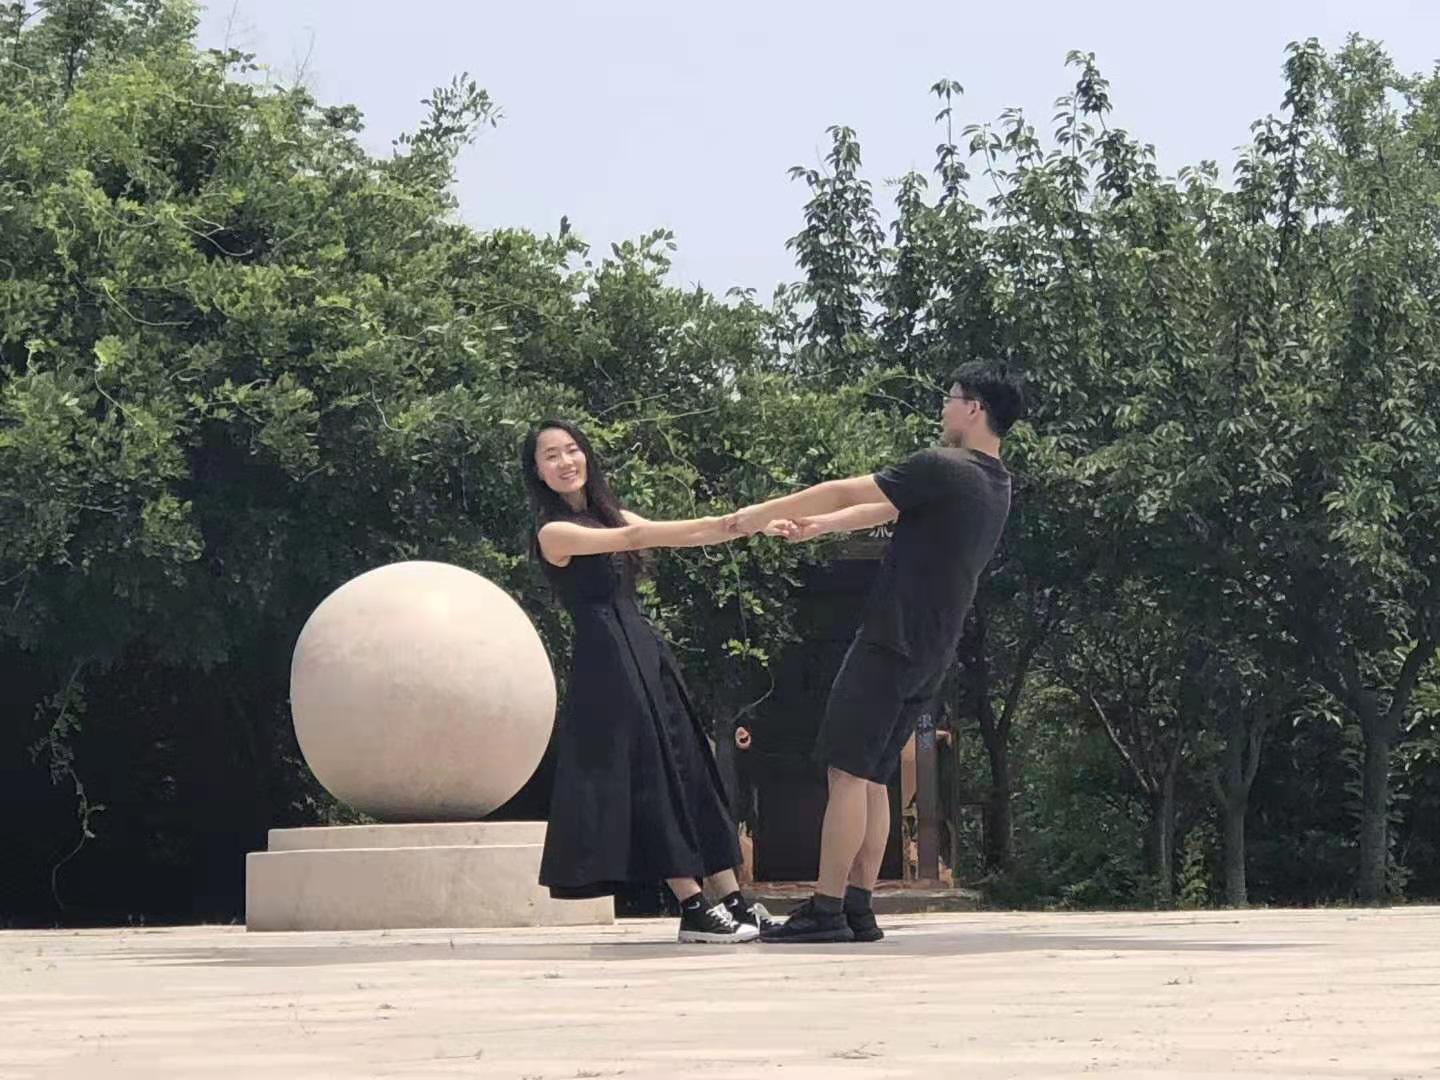

In [1]:
from IPython.display import Image,display
print("原图：")
Image(filename = './images/couple.jpg', width=200, height=150)

风格图1：


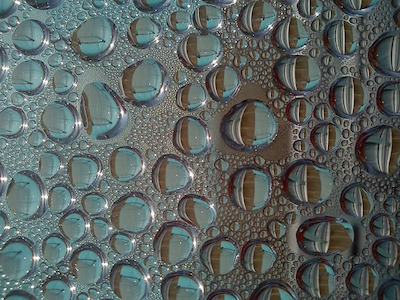

风格图2：


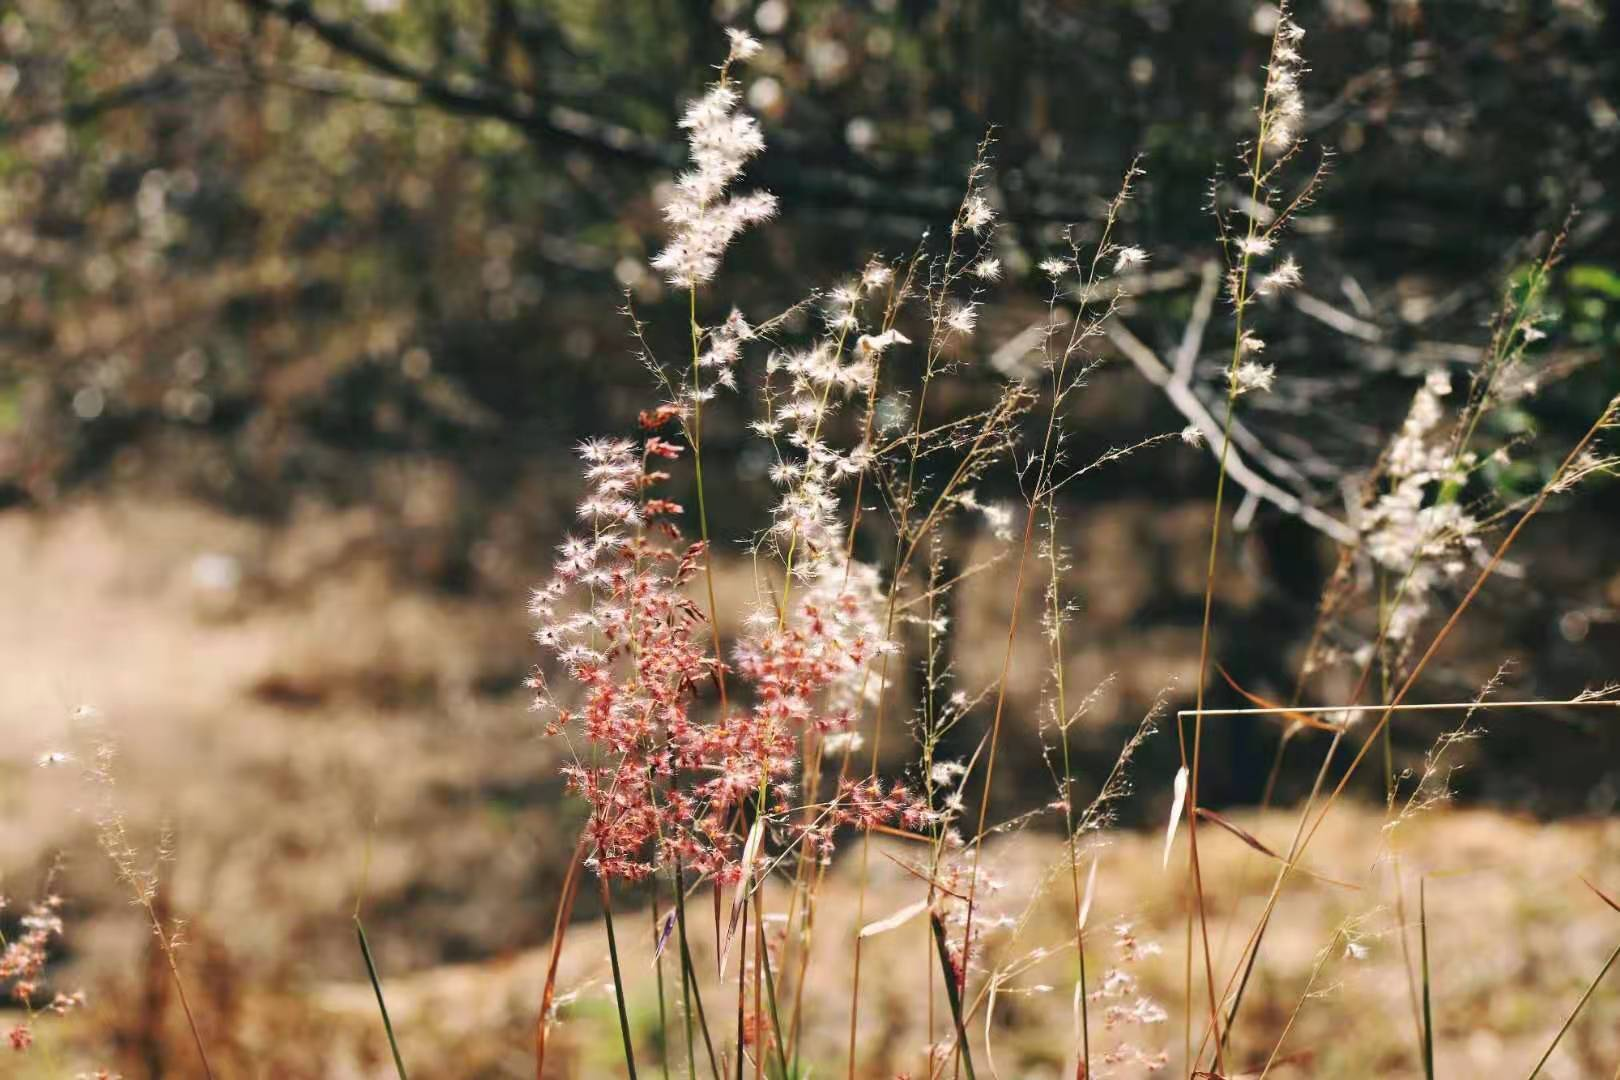

风格图3：


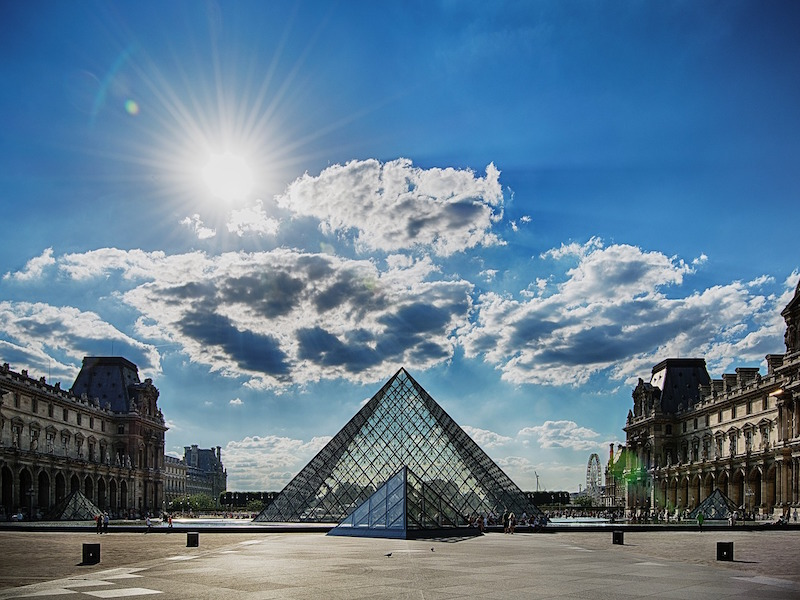

In [2]:
print("风格图1：")
img1 = Image(filename = './images/drop-of-water.jpg', width=200, height=150)
display(img1)
print("风格图2：")
img2 = Image(filename = './images/flower.jpg', width=200, height=150)
display(img2)
print("风格图3：")
img3 = Image(filename = './images/louvre.jpg', width=200, height=150)
display(img3)

效果图1：


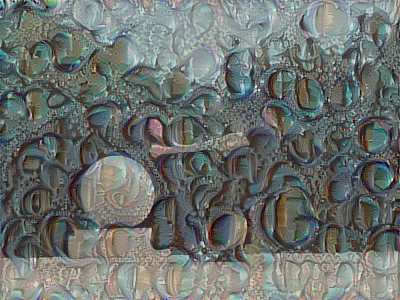

效果图2：


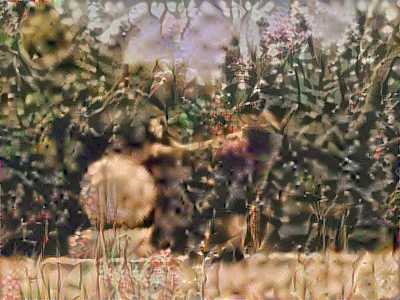

效果图3：


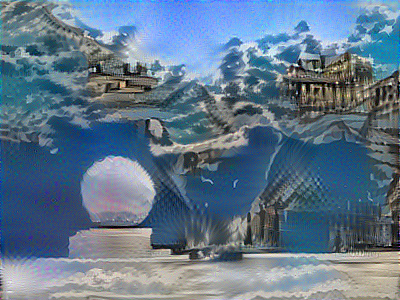

In [3]:
print("效果图1：")
img1 = Image(filename = './images/520water.png', width=200, height=150)
display(img1)
print("效果图2：")
img2 = Image(filename = './images/520flo.png', width=200, height=150)
display(img2)
print("效果图3：")
img3 = Image(filename = './images/520paris.png', width=200, height=150)
display(img3)